In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import tensorflow as tf
import scipy.stats
import pandas as pd
from tensorflow.contrib.metrics import streaming_pearson_correlation
from keras.models import load_model
from functools import partial
from sklearn.preprocessing import maxabs_scale, minmax_scale, normalize, scale, robust_scale

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [109]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
import src.flux_utils as futils
import src.flux_sample as fs
import src.create_dataset as dataset
import src.cf_io as cf_io
import src.plotting as plotting
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_csv('../data/karim_data.CSV')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
n_experiments = df.shape[0]
df.head()

,AVG,STD,AVG.1,STD.1,mg2,nh4,k,glc__D,pi,nad,atp,coa
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [7]:
X_train, y_train, X_test, y_test, obj_col, cols = futils.read_data('../data/f2000', 'karim_karim_ecoli_cf_base.sbml_fluxes',
                                                                    n_experiments, 'DM_btol_c', resamp=False, scale='flux_zero')

2
Min: 0.0, Max: 1.0


In [ ]:
import h5py
h5f = h5py.File('../data/karim_stacked_fluxes', 'w')
h5f.create_dataset('X_train', data=X_train, type=np.float32)
h5f.create_dataset('X_test', data=X_test, type=np.float32)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('obj_col', data=obj_col)
h5f.create_dataset('cols', data=cols)
h5f.close()

In [18]:
y_vals = futils.scale_data(data=df['AVG.1'].values, scale_type='flux_zero', in_place=False)

1


In [56]:
froot = 'hand'
txtl = False
resamp = False
fname = '../data/{0}{1}_{2}_fluxes'.format(froot, '_txtl' if txtl else '', 'stacked' if resamp else 'flat')

In [57]:
X_train, y_train, X_test, y_test, obj_col, cols, y_vals_d = dataset.get_dataset(fname)
y_vals = np.array(y_vals_d)

In [19]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error as mse
class LossHistory(Callback):
    def __init__(self):
        self.recon_losses = []
        self.kl_losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        y_true = self.validation_data[0]
        y_pred = self.model.predict(self.validation_data[0])
        xent_loss = y_true.shape[-1] * np.mean(np.square(y_true - y_pred), axis=-1)
        inputs = [K.learning_phase()] + self.model.inputs
        zvar = K.function(inputs=inputs, outputs=[self.model.get_layer('z_log_var').output])
        zmn = K.function(inputs=inputs, outputs=[self.model.get_layer('z_mean').output])
        z_log_var = zvar([0, self.validation_data[0]])[0]
        z_mean = zmn([0, self.validation_data[0]])[0]
        kl_loss = - 0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)
        print "Reconstruction loss: {0}".format(np.mean(xent_loss))
        print "KL loss: {0}".format(np.mean(kl_loss))
        self.recon_losses.append(np.mean(xent_loss))
        self.kl_losses.append(np.mean(kl_loss))

In [20]:
layer_sizes = [1024, 256]

In [21]:
latent_dim = 2
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def corr_loss(y_true, y_pred):
    cent_pred = y_pred - K.mean(y_pred)
    cent_tr = y_true - K.mean(y_true)

    std_pred = K.std(y_pred)
    std_tr = K.std(y_true)
    return K.mean(cent_pred*cent_tr)/(std_pred*std_tr)

def kl_loss(z_log_var, z_mean):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def build_vae(X_shape, n_experiments, targets, output_ind, batch_size=100):
    encoded_dim1 = 1024
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(X_shape,))
    #h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(x)#h)
    z_mean = Dense(latent_dim, name='z_mean')(h)
    z_log_var = Dense(latent_dim, name='z_log_var')(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    #decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='tanh')
    h_decoded = decoder_h(z)
    #h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)#2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    #vae = Model(x, [x_decoded_mean, x_decoded_mean])
    #output_flux = x_decoded_mean[:, :, output_ind]
    #experiment_loss = scipy.stats.spearmanr(targets, output_flux)
    #experiment_loss_val = -1 * corr_loss(targets, output_flux)#streaming_pearson_correlation(output_flux, targets)
    xent_loss = x.shape[-1].value * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss_val = kl_loss(z_log_var, z_mean)
    vae_loss = K.mean(xent_loss + kl_loss_val)# + experiment_loss_val
    #print x.shape, x_decoded_mean.shape, z_mean.shape, z_log_var.shape
    #print xent_loss.shape, kl_loss_val.shape, experiment_loss_val.shape, vae_loss.shape
    #vae_loss = K.sum(vae_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.compile(optimizer='rmsprop', loss=[lambda x, x_pred: gen_vae_loss(x, x_pred, z_log_var, z_mean),
    #                                       lambda x, x_pred: corr_loss(targets, x_pred[:, :, output_ind])])
    vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    #_h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)#2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [51]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [58]:
#%%debug
batch_size = 256
n_epochs = 100
X_shape, n_experiments = X_train.shape[1], df.shape[0]
targets = tf.convert_to_tensor(y_vals, dtype=tf.float32)
vae, encoder, generator = build_vae(X_shape, n_experiments, targets, obj_col, batch_size)
es = EarlyStopping(patience=10)
#lh = LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist = vae.fit(X_train,
        shuffle='batch',
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es])
encoder.save('flat_encoder_dim=2_{0}_layers={1}_epochs={2}.h5'.format(scale, len(layer_sizes), n_epochs))
generator.save('flat_generator_dim=2_{0}_layers={1}_epochs={2}.h5'.format(scale, len(layer_sizes), n_epochs))

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/ipykernel_launcher.py:55 UserWarning: Output "dense_18" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_18" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 2637)         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          675328      input_11[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_16[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_16[0][0]                   
__________________________________________________________________________________________________
lambda_6 (

KeyboardInterrupt: 

In [62]:
latent_dim = 10
vae2, encoder2, generator2 = build_vae(X_shape, n_experiments, targets, output_ind, batch_size)
es = EarlyStopping(patience=10)
lh2 = LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist2 = vae2.fit(X_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es, lh])
encoder2.save('flat_encoder_dim=10_{0}.h5'.format(scale))
generator2.save('flat_generator_dim=10_{0}.h5'.format(scale))

62145/62145 [==============================] - 7s 115us/step - loss: 10.5563 - val_loss: 10.4581
Reconstruction loss: 8.35130768297
KL loss: 2.12197971344
Epoch 7/100
62145/62145 [==============================] - 6s 103us/step - loss: 10.3842 - val_loss: 10.3363
Reconstruction loss: 8.26996534042
KL loss: 2.07983565331
Epoch 8/100
62145/62145 [==============================] - 6s 96us/step - loss: 10.2725 - val_loss: 10.0638
Reconstruction loss: 7.9369064339
KL loss: 2.10778617859
Epoch 9/100
62145/62145 [==============================] - 5s 81us/step - loss: 10.1938 - val_loss: 10.2264
Reconstruction loss: 7.92137890554
KL loss: 2.2857336998
Epoch 10/100
62145/62145 [==============================] - 8s 125us/step - loss: 10.1233 - val_loss: 10.0565
Reconstruction loss: 7.99250593848
KL loss: 2.03997516632
Epoch 11/100
62145/62145 [==============================] - 10s 158us/step - loss: 10.0728 - val_loss: 10.1134
Reconstruction loss: 7.77172402157
KL loss: 2.34678387642
Epoch 12/10

In [3]:
latent_dim = 2
use_corr = True
froot = 'hand'
txtl = True
resamp = True
layer_szs = [1024, 1024, 1024]
flat = not resamp
#encoder_epochs=200_batch=256_dimension=10_corr=True_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True.h5
#losses_epochs=200_batch=256_dimension=2_corr=True_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True_lastlayer=1024.h5

In [34]:
df = cf_io.get_exp_data('manual')

(1591, 38)


In [9]:
encoder, generator, X_test, y_test, obj_col, cols, y_vals_d, test_enc, test_dec = cf_io.get_test_data(
    froot, txtl, resamp, latent_dim, layer_szs, use_corr=True)

Load models ../models/encoder_epochs=200_batch=256_dimension=2_corr=True_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True_lastlayer=1024.h5


/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/keras/models.py:282 UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


Read in data from ../data/hand_txtl_stacked_fluxes
Encoded data
Decoded data


In [106]:
latent_dim = 2
use_corr = False
froot = 'hand'
txtl = True
resamp = True
layer_szs = [1024, 1024, 1024]
flat = not resamp
#encoder_epochs=200_batch=256_dimension=10_corr=True_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True.h5
#losses_epochs=200_batch=256_dimension=2_corr=True_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True_lastlayer=1024.h5

In [107]:
encoder_nc, generator_nc, X_test_nc, y_test_nc, obj_col_nc, cols_nc, y_vals_d_nc, test_enc_nc, test_dec_nc = cf_io.get_test_data(
    froot, txtl, resamp, latent_dim, layer_szs, use_corr=False)

Load models ../models/encoder_epochs=200_batch=256_dimension=2_corr=False_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=True_lastlayer=1024.h5
Read in data from ../data/hand_txtl_stacked_fluxes
Encoded data
Decoded data


In [10]:
use_corr = False
resamp = False

In [11]:
encoder_f, generator_f, X_test_f, y_test_f, obj_col_f, cols_f, y_vals_d_f, test_enc_f, test_dec_f = cf_io.get_test_data(
    froot, txtl, resamp, latent_dim, layer_szs, use_corr=True)

Load models ../models/encoder_epochs=200_batch=256_dimension=2_corr=False_scale=flux_zero_froot=hand_txtl=True_nlayers=3_resamp=False_lastlayer=1024.h5
Read in data from ../data/hand_txtl_flat_fluxes
Encoded data
Decoded data


Plot d_1 vs d_2
Plot d_1 vs d_2


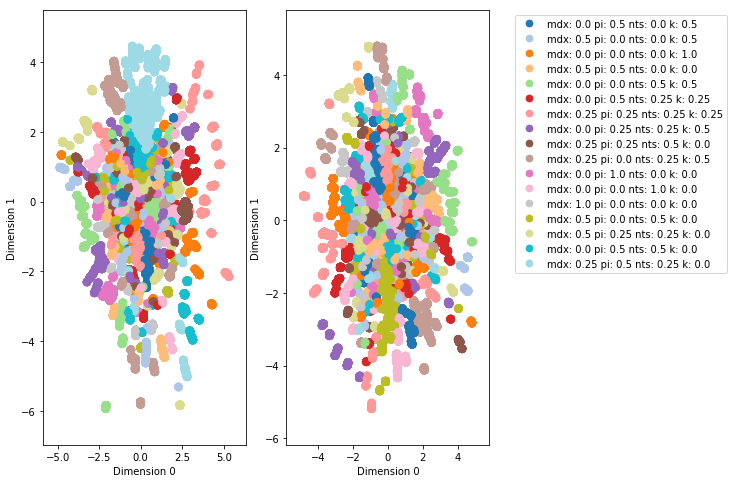

In [113]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
plotting.plt_latent_space(encoded_data=test_enc, df=df, ax=axarr[0], legend=False)
plotting.plt_latent_space(encoded_data=test_enc_nc, df=df, ax=axarr[1])

[9002 2778]


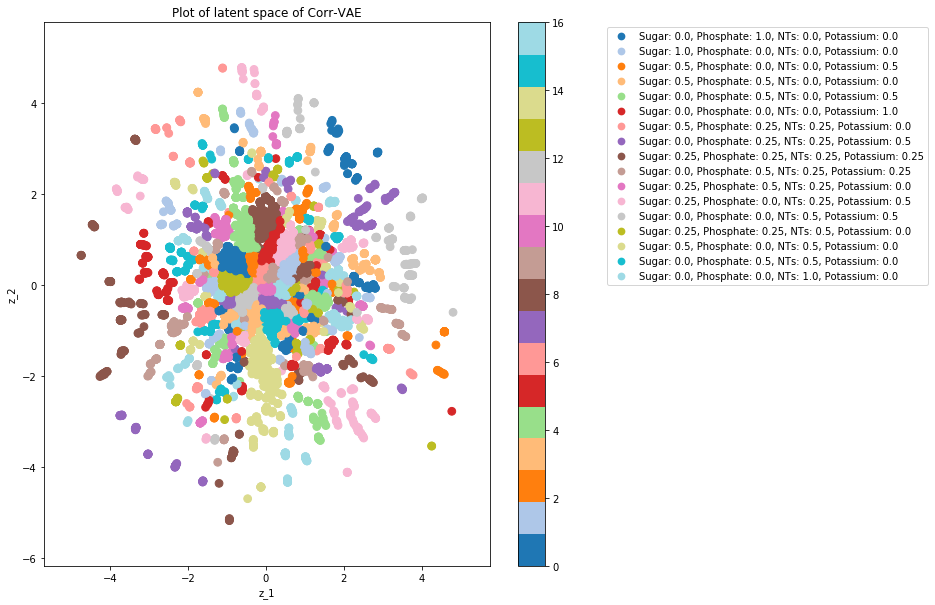

In [108]:
x_test_encoded = test_enc
df_sor = df.sort_values(by='nts')
ind = df_sor.index
cmap = cm.get_cmap('tab20', 17)#tab20
#cmap = discrete_cmap(41, 'cubehelix')
#for j in range(4):

high_cols = (test_enc[:, 1] > 0)
print sum(high_cols)
#for i in range(latent_dim):
    #for j in range(i + 1, latent_dim):
i = 0
j = 1
low, high = 10, 1000#3000
colors = np.array([[k] * (high - low) for k in range(17)]).T
xmin, xmax = np.amin(x_test_encoded[low:high, ind, i]), np.amax(x_test_encoded[low:high, ind, i])
ymin, ymax = np.amin(x_test_encoded[low:high, ind, j]), np.amax(x_test_encoded[low:high, ind, j])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
#for col in df.columns[4:]:
plt.figure(figsize=(10, 10))
sz = 60
#for ix, idx in enumerate(ind):
#    print idx
#plt.scatter(x_test_encoded[low:high, idx, i], x_test_encoded[low:high, idx, j], c=[cmap.colors[ix]] * (high - low), 
#                cmap=cmap, s=sz,
#                label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
#                            df_sor.loc[idx, 'mdx'], df_sor.loc[idx, 'pi'], df_sor.loc[idx, 'nts'], df_sor.loc[idx, 'k'])
#                )#, norm=norm)#get_rct(df, col, y_test), cmap=cmap)
sc = plt.scatter(x_test_encoded[low:high, ind, i], x_test_encoded[low:high, ind, j], c=colors, 
                cmap=cmap, s=sz)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
lp = lambda k: plt.plot([],color=sc.cmap(sc.norm(k)), ms=np.sqrt(sz), mec="none",
                        label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
                            df_sor.iloc[k, 0], df_sor.iloc[k, 1], df_sor.iloc[k, 2], df_sor.iloc[k, 3]), 
                        ls="", marker="o")[0]
handles = [lp(k) for k in np.unique(range(17))]
plt.legend(bbox_to_anchor=(1.25, 1.0))#handles=handles, 
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.title('Plot of latent space of Corr-VAE')
plt.colorbar()
plt.show()

In [421]:
y_test_f

array([ 5,  7, 14, ...,  4,  6, 14])

[9002 2778]


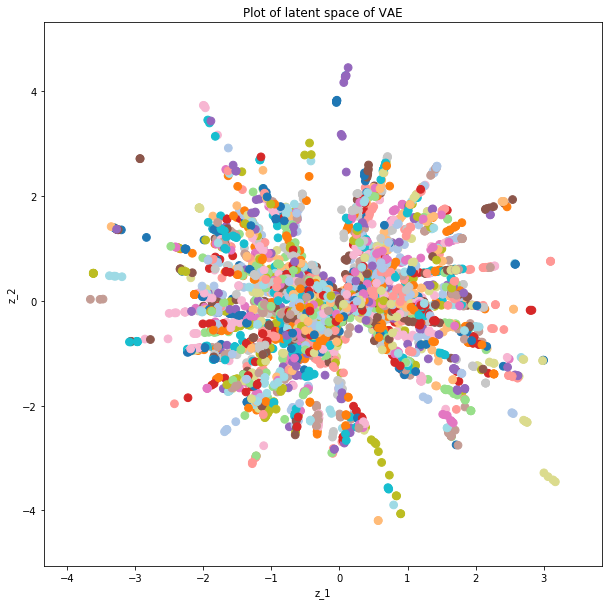

In [426]:
x_test_encoded = test_enc_f
df_sor = df.sort_values(by='nts')
ind = df_sor.index
cmap = cm.get_cmap('tab20', 17)#tab20
#cmap = discrete_cmap(41, 'cubehelix')
#for j in range(4):

high_cols = (test_enc[:, 1] > 0)
print sum(high_cols)
#for i in range(latent_dim):
    #for j in range(i + 1, latent_dim):
i = 0
j = 1
low, high = 10, 5000#3000
#colors = np.array([[k] * (high - low) for k in range(17)]).T
xmin, xmax = np.amin(x_test_encoded[low:high, i]), np.amax(x_test_encoded[low:high, i])
ymin, ymax = np.amin(x_test_encoded[low:high, j]), np.amax(x_test_encoded[low:high, j])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
#for col in df.columns[4:]:
plt.figure(figsize=(10, 10))
sz = 60
#for ix, idx in enumerate(ind):
#    print idx
#plt.scatter(x_test_encoded[low:high, idx, i], x_test_encoded[low:high, idx, j], c=[cmap.colors[ix]] * (high - low), 
#                cmap=cmap, s=sz,
#                label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
#                            df_sor.loc[idx, 'mdx'], df_sor.loc[idx, 'pi'], df_sor.loc[idx, 'nts'], df_sor.loc[idx, 'k'])
#                )#, norm=norm)#get_rct(df, col, y_test), cmap=cmap)
sc = plt.scatter(x_test_encoded[low:high, i], x_test_encoded[low:high, j], c=y_test_f[low:high], 
                cmap=cmap, s=sz)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
lp = lambda k: plt.plot([],color=sc.cmap(sc.norm(k)), ms=np.sqrt(sz), mec="none",
                        label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
                            df_sor.iloc[k, 0], df_sor.iloc[k, 1], df_sor.iloc[k, 2], df_sor.iloc[k, 3]), 
                        ls="", marker="o")[0]
handles = [lp(k) for k in np.unique(range(17))]
#plt.legend(bbox_to_anchor=(1.25, 1.0))#handles=handles, 
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.title('Plot of latent space of VAE')
#plt.colorbar()
plt.show()

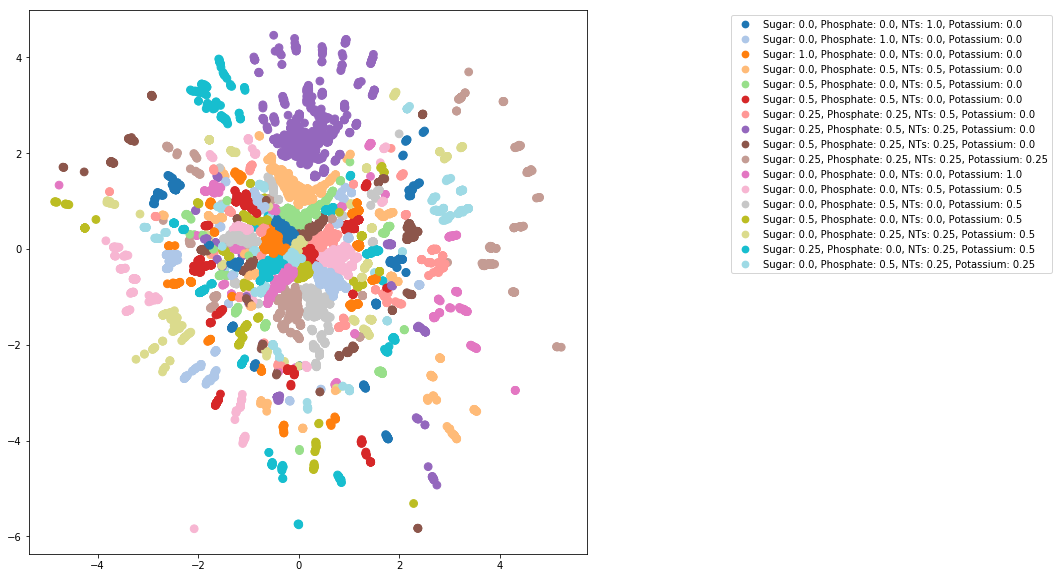

In [380]:
plt.figure(figsize=(10, 10))
colors = np.array([[k] * (high - low) for k in range(17)]).T
sc = plt.scatter(x_test_encoded[low:high, :, i], x_test_encoded[low:high, :, j], c=colors, 
                cmap=cmap, s=sz)
lp = lambda k: plt.plot([],color=sc.cmap(sc.norm(k)), ms=np.sqrt(sz), mec="none",
                        label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
                            df.loc[k, 'mdx'], df.loc[k, 'pi'], df.loc[k, 'nts'], df.loc[k, 'k']), 
                        ls="", marker="o")[0]
handles = [lp(k) for k in np.unique(range(17))]
plt.legend(bbox_to_anchor=(1.25, 1.0))

In [ ]:
np.random.seed(42)
inds = np.sort(np.random.choice(X_test.shape[0], size=1000, replace=False))
st_test = X_test[inds, : , :]
fl_test = X_test[inds, : , :].reshape(st_test.shape[0] * st_test.shape[1], st_test.shape[2])
fl_y = np.array([i for i in range(st_test.shape[1]) for j in range(st_test.shape[0])])
st_enc = encoder.predict(st_test)
fl_enc = encoder_f.predict(fl_test)

In [83]:
np.random.seed(42)
plt_inds = np.random.choice(fl_test.shape[0], size=1000, replace=False)

(array([8.546e+03, 3.000e+01, 1.000e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([0.       , 0.0999984, 0.1999968, 0.2999952, 0.3999936, 0.499992 ,
        0.5999904, 0.6999888, 0.7999872, 0.8999856, 0.999984 ]),
 <a list of 10 Patch objects>)

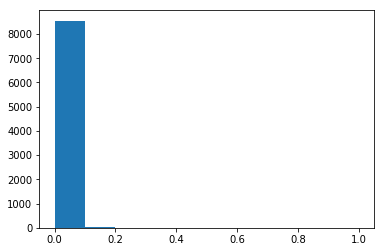

In [105]:
plt.hist(X_test_f[:, 1])

Plot d_1 vs d_2


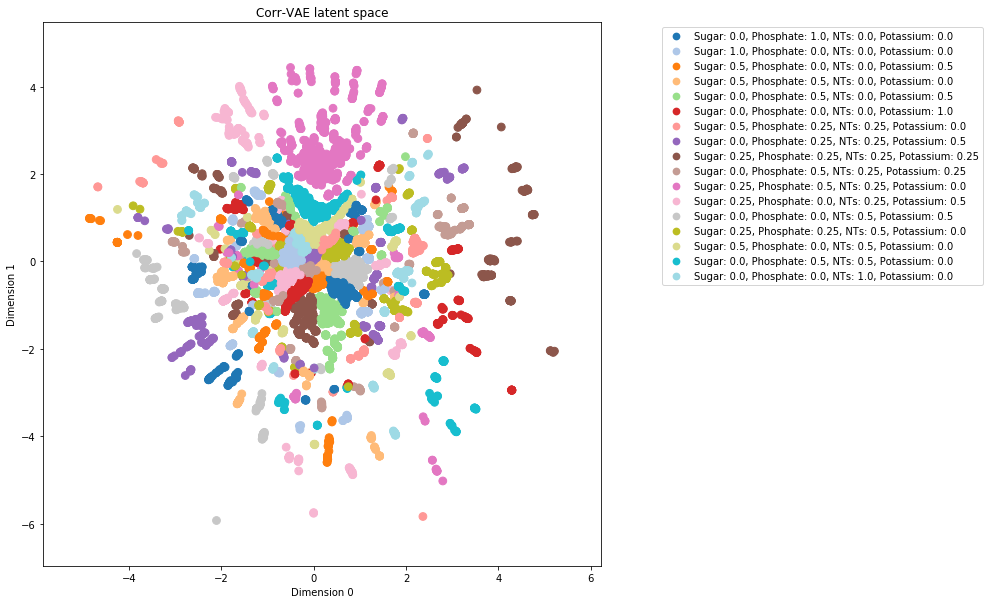

In [99]:
def plt_latent_space(encoded_data, df, ax, y_test=None, flat=False, dim_1=0, dim_2=1, samp_range=None,
                     color_scheme='tab20', sz=60, legend=True, label='Dimension'):
    df_sor = df.sort_values(by='nts')
    n_experiments = df.shape[0]
    ind = df_sor.index
    cmap = cm.get_cmap(color_scheme, 17)

    if samp_range is not None:
        #low, high = samp_range
        if type(samp_range) == int:
            samp_range = range(samp_range)
        encoded_data = encoded_data[samp_range]
        if y_test is not None:
            y_test = y_test[samp_range]
    if flat:
        colors = y_test
        d_1 = encoded_data[:, dim_1]
        d_2 = encoded_data[:, dim_2]
    else:
        colors = np.array([[k] * encoded_data.shape[0] for k in range(n_experiments)]).T
        d_1 = encoded_data[:, ind, dim_1]
        d_2 = encoded_data[:, ind, dim_2]

    xmin, xmax = np.amin(d_1), np.amax(d_1)
    ymin, ymax = np.amin(d_2), np.amax(d_2)
    x_diff = (xmax - xmin) / 10.0
    y_diff = (ymax - ymin) / 10.0    
    print 'Plot d_1 vs d_2'
    sc = ax.scatter(d_1, d_2, c=colors, cmap=cmap, s=sz)
    ax.set_xlim((xmin - x_diff, xmax + x_diff))
    ax.set_ylim((ymin - y_diff, ymax + y_diff))
    if legend:
        lp = lambda k: ax.plot([],color=sc.cmap(sc.norm(k)), ms=np.sqrt(sz), mec="none",
                                label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
                                    df_sor.iloc[k, 0], df_sor.iloc[k, 1], df_sor.iloc[k, 2], df_sor.iloc[k, 3]), 
                                ls="", marker="o")[0]
        handles = [lp(k) for k in np.unique(range(17))]
        ax.legend(bbox_to_anchor=(1.1, 1.0))#handles=handles, 
    ax.set_xlabel('{0} {1}'.format(label, dim_1))
    ax.set_ylabel('{0} {1}'.format(label, dim_2))
    
axarr = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))[1]
#plt_latent_space(fl_enc, df, axarr[0], flat=True, y_test=fl_y, samp_range=plt_inds, legend=False)
#axarr[0].set_title('VAE latent space')
plt_latent_space(st_enc, df, axarr, samp_range=range(1000), legend=True)
axarr.set_title('Corr-VAE latent space')
plt.show()

In [41]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=2)
enc_pca = pca.fit_transform(fl_test)

Plot d_1 vs d_2
Plot d_1 vs d_2


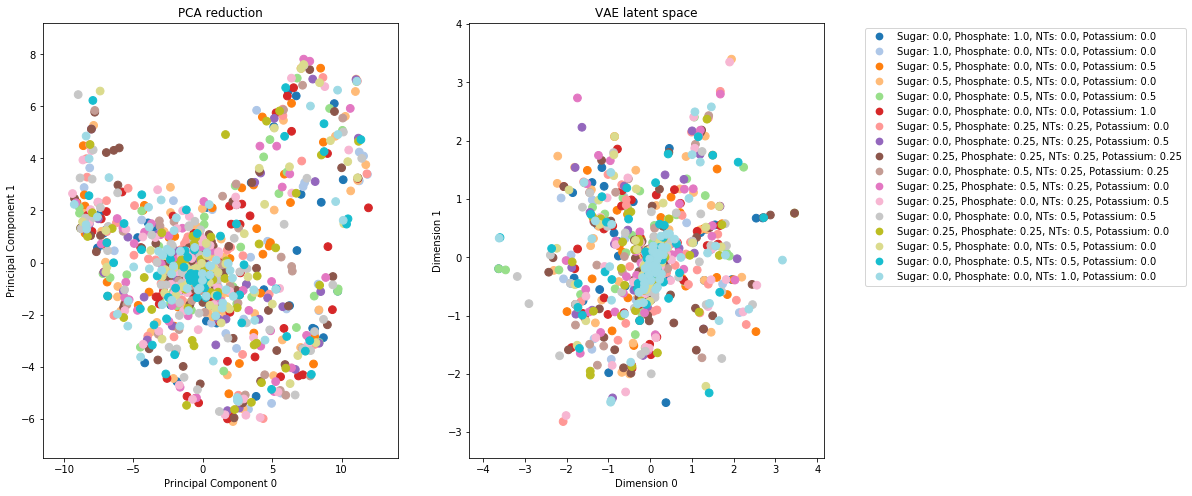

In [96]:
axarr = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))[1]
plt_latent_space(enc_pca, df, axarr[0], flat=True, y_test=fl_y, samp_range=plt_inds, legend=False, label='Principal Component')
axarr[0].set_title('PCA reduction')
plt_latent_space(fl_enc, df, axarr[1], flat=True, y_test=fl_y, samp_range=plt_inds, legend=True)
axarr[1].set_title('VAE latent space')
plt.show()

In [71]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [77]:
import matplotlib as mpl

In [ ]:
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

In [94]:
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5,.5,.5,1.0)
cmaplist[1] = (.5,.5,.5,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,40,41)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [118]:
df[df['Glucose'] < 200]

,Area_1,Area_2,Conc_1,Conc_2,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
19,12979.5,8512.2,8.28,5.43,6.86,2.02,0.51,0.15,8.0,10.0,134,120,10,0.5,0.0,0.5
27,14757.7,11211.6,9.42,7.15,8.29,1.60,0.61,0.12,8.0,10.0,134,40,10,0.5,0.0,0.5
29,15992.3,11871.9,10.21,7.58,8.89,1.86,0.66,0.14,8.0,10.0,134,160,10,0.5,0.0,0.5


In [100]:
from sklearn.manifold import TSNE

In [101]:
tsne = TSNE(n_components=2)

In [122]:
lh = test_enc[low:high, : , :]

In [129]:
lh[0, 1 , 0]

0.00784448

In [124]:
test_enc_2d[1, 0]

0.00784448

In [114]:
test_enc_2d = test_enc[low:high, : , :].reshape((high - low) * test_enc.shape[1], test_enc.shape[2])

In [115]:
X_embedded = tsne.fit_transform(test_enc_2d)
#X_embedded2 = tsne.fit_transform(test_enc[low:high, : , 2])

In [132]:
X_embedded.shape

(3230, 2)

In [136]:
col = np.array(range(17) * lh.shape[0])
col[:5]
col.shape

(3230,)

In [145]:
df = fs.get_exp_data('hand')

(1591, 38)


In [148]:
for _, row in df.iterrows():
    print 'Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(row['mdx'], row['pi'], row['nts'], row['k'])
    break

Sugar: 0.0, Phosphate: 0.0, NTs: 1.0, Potassium: 0.0


Text(0.5,1,'TSNE reduction of latent space')

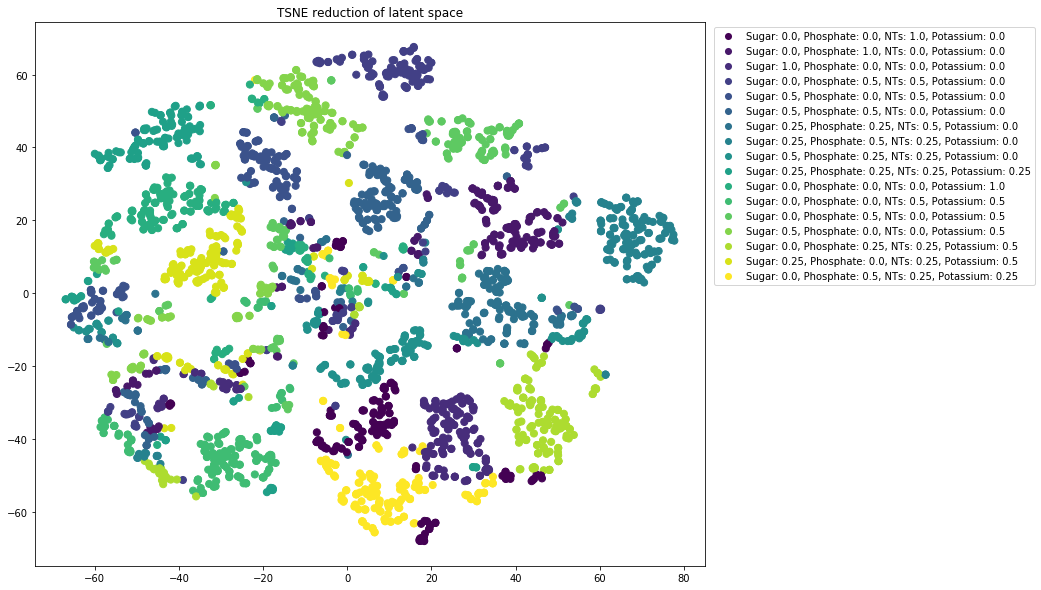

In [153]:
plt.figure(figsize=(12, 10))
sz = 50
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=col, s=sz)
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(sz), mec="none",
                        label='Sugar: {0}, Phosphate: {1}, NTs: {2}, Potassium: {3}'.format(
                            df.loc[i, 'mdx'], df.loc[i, 'pi'], df.loc[i, 'nts'], df.loc[i, 'k']), 
                        ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(col)]
plt.legend(handles=handles, bbox_to_anchor=(1.5, 1.0))
plt.title('TSNE reduction of latent space')
#plt.legend(range(17))

In [290]:
#txtl = True
rxn_amt = 5
addl_amt = 1
batch_size = 50
n_batches = batch_size / rxn_amt
model_f = '{0}_ecoli_cf_base{1}.sbml'.format('nls', '_txtl' if txtl else '')
#model_f = '../models/ColiPruned.xml'
#model_f = '../models/nls_ecoli_cf_varner.json.sbml'

print 'Read in data'
df = fs.get_exp_data(froot)
#df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)

cfps_conc = pd.read_csv('../data/{0}_concs'.format('nls'), index_col='compound')
if not froot == 'karim':
    cfps_conc.drop('final_conc', inplace=True, axis=1)
    nrg_mix = pd.read_csv('../data/energy_mix.csv', index_col='compound')
else:
    nrg_mix = None
#print cfps_conc

print 'Time to generate model specific conditions'
model = cobra.io.read_sbml_model('../models/{0}'.format(model_f))
print 'Model {0} read in'.format(model_f)

Read in data
(1591, 38)
Time to generate model specific conditions
Model nls_ecoli_cf_base_txtl.sbml read in


In [292]:
model.objective.expression

-1.0*DM_PROTEIN_RFP_reverse_9d496 + 1.0*DM_PROTEIN_RFP

In [294]:
fluxes = []
objs = []
for idx, row in df.iterrows():
    print idx
    cfps_conc_tmp = cfps_conc.copy()
    cfps_conc_tmp = fs.update_vals(cfps_conc_tmp, row, n_batches, nrg_mix=nrg_mix, replace=froot == 'karim')
    tot_rxn_amt = rxn_amt + addl_amt
    if froot == 'karim':
        exp_concs = cfps_conc_tmp['final_conc']
    else:
        exp_concs = fs.conc_dilution(cfps_conc_tmp['start_conc'], (rxn_amt / 5.0) * cfps_conc_tmp['amt'], tot_rxn_amt)
    model_i = fs.change_conc(model, exp_concs)
    model_i.objective = model_i.reactions.PROTEIN_export_RFP
    #print model_i.reactions.EX_mg2_c.bounds
    #print model_i.reactions.EX_pi_c.bounds
    sol = model_i.optimize()
    fluxes.append(sol.fluxes)
    objs.append(sol.objective_value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [405]:
import os

In [404]:
model_i.reactions.BIOMASS_Ec_iJO1366_core_53p95M

Name,iJO1366
Memory address,0x05e685d90
Number of metabolites,1144
Number of reactions,2666
Objective expression,1.0*PROTEIN_export_RFP - 1.0*PROTEIN_export_RFP_reverse_7fe1d
Compartments,cytosol


In [295]:
scipy.stats.pearsonr(y_vals, objs)#fl[0, :, 2665])

(0.2259144139691087, 0.3832788550061067)

In [296]:
cols_l = list(cols)

In [297]:
fl = np.array(fluxes).reshape(1, 17, 2666)

In [298]:
enc = encoder.predict(fl)
dec = generator.predict(enc)

In [243]:
y_vals

array([0.48554169, 0.43504129, 0.51335141, 0.96439722, 0.71302366,
       0.04782136, 0.29335328, 1.        , 0.95133094, 0.24244459,
       0.03943087, 0.07384195, 0.        , 0.00778542, 0.25700919,
       0.37552736, 0.12103322])

In [301]:
dec[0, :, obj_col.value]

array([2.9889800e-06, 2.6624737e-06, 2.9582257e-06, 2.7320689e-06,
       2.9875553e-06, 2.7280776e-06, 2.8278112e-06, 2.7300712e-06,
       2.8266409e-06, 2.8278919e-06, 2.9892824e-06, 2.9891285e-06,
       2.7322460e-06, 2.9877062e-06, 2.8291490e-06, 2.9884159e-06,
       2.7321576e-06], dtype=float32)

In [303]:
scipy.stats.pearsonr(y_vals, dec[0, :, obj_col.value])

(0.13878016890619108, 0.5952782713945028)

In [254]:
scipy.stats.pearsonr(y_vals, objs)#fl[0, :, 2665])

(nan, 1.0)

In [186]:
fl[0, :, obj_col.value]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [203]:
s = fluxes[1]#['DM_PROTEIN_RFP']
s.index.get_loc('DM_PROTEIN_RFP')

2665

In [202]:
s.index.get_loc('DM_PROTEIN_RFP')

2665

In [232]:
res_df = pd.DataFrame(objs)
res_df['Actual'] = df['OUT']
res_df.head()

,0,Actual
0,0.001297,0.566331
1,0.001305,0.523761
2,0.001300,0.589774
3,0.001301,0.969988
4,0.001299,0.758090
